Neural network to get galaxy type, Here only two types. 

In [1]:
#standard libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
import sys
import os
#wcs is incompabible with newest numpy thus below not used 
#from astropy import wcs
#to access astronomical images in fits format
from astropy.io import fits
#torch functions
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
#sklearn helper functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,f1_score, log_loss
#xgboost for comparison
from xgboost import XGBClassifier
#logistic regression for comparison 
from sklearn.linear_model import LogisticRegression

Getting the data. It are currently four fields. 

In [2]:
cutouts1=np.load("stripe82_1_ell_spiral_im.npy")
cutouts2=np.load("stripe82_2_ell_spiral_im.npy")
cutouts3=np.load("stripe82_3_ell_spiral_im.npy")
cutouts4=np.load("stripe82_4_ell_spiral_im.npy")
print(cutouts1.shape)
df1=pd.read_csv("stripe82_1_ell_spiral_table.csv")
df2=pd.read_csv("stripe82_2_ell_spiral_table.csv")
df3=pd.read_csv("stripe82_3_ell_spiral_table.csv")
df4=pd.read_csv("stripe82_4_ell_spiral_table.csv")
print(df1.columns)

(43, 43, 1, 168)
Index(['Unnamed: 0', 'index', 'objid', 'ra', 'dec', 'psfMag_u', 'psfMag_g',
       'psfMag_r', 'psfMag_i', 'psfMag_z', 'probPSF_u', 'probPSF_g',
       'probPSF_r', 'probPSF_i', 'probPSF_z', 'modelMag_u', 'modelMag_g',
       'modelMag_r', 'modelMag_i', 'modelMag_z', 'petroRad_g', 'petroRad_r',
       'petroRad_i', 'run', 'rerun', 'camcol', 'field', 'type', 'specobjid',
       'class', 'subclass', 'redshift', 'plate', 'mjd', 'fiberid', 'nvote',
       'p_el', 'p_cw', 'p_acw', 'p_edge', 'p_dk', 'p_mg', 'p_el_debiased',
       'p_cs_debiased', 'spiral', 'elliptical', 'uncertain', 'image',
       'pixel_x', 'pixel_y', 'off_image'],
      dtype='object')


Now I built the function to combine the four numpy arrays.

In [3]:
#combines numpy arrays of 4d shape, same shape first 3, last variable
def comb_nump_4d(input_list):
    l=0
    for i in range(len(input_list)):
        l+=input_list[i].shape[3]
    combined=np.zeros((input_list[0].shape[0],input_list[0].shape[1],input_list[0].shape[2],l))
    l=0
    for i in range(len(input_list)):
        combined[:,:,:,l:l+input_list[i].shape[3]]=input_list[i]
        l+=input_list[i].shape[3]  
    return combined

Combining the images. 

In [4]:
cutout_lists=[cutouts1,cutouts2,cutouts3,cutouts4]
cutouts=comb_nump_4d(cutout_lists)

Now combining the data frames with the classfications and more meta data. 

In [5]:
df=pd.concat([df1,df2,df3,df4],ignore_index=True)
print(df1.head(),df.head(),df4.tail(),df.tail())

   Unnamed: 0  index                objid         ra       dec  psfMag_u  \
0           0      1  1237663237128388701  50.130513 -1.228488  22.01211   
1           1    123  1237666299481817102  50.160628 -1.035026  19.01124   
2           2    140  1237663237128388949  50.167304 -1.241885  22.36878   
3           3    458  1237666300018557091  50.006004 -0.495751  21.98376   
4           4    110  1237663238739067202  50.387910  0.198944  21.86834   

   psfMag_g  psfMag_r  psfMag_i  psfMag_z  ...   p_mg  p_el_debiased  \
0  20.06700  18.86854  18.35853  17.93478  ...  0.032          0.935   
1  17.46116  16.85288  16.54355  16.19304  ...  0.000          0.971   
2  20.17246  18.94735  18.44240  17.99196  ...  0.000          0.964   
3  19.93291  18.73658  18.31895  17.89719  ...  0.000          0.893   
4  19.78908  18.63620  18.16101  17.63892  ...  0.018          0.755   

   p_cs_debiased  spiral  elliptical  uncertain  image      pixel_x  \
0          0.000       0           1   

Has worked, now looking on classes. 

In [6]:
print(df.spiral.value_counts())

1    504
0    206
Name: spiral, dtype: int64


Somewhat inbalanced, clearly more spirals than ellipctical galaxies.
 
Now adding columns to data frame that also other algorithms can work on it. 

In [16]:
x=0
for i in range(cutouts.shape[0]):
    for j in range(cutouts.shape[1]):
        df[x]=cutouts[i,j,0,:]
        x+=1
print(df)        

     Unnamed: 0  index                objid         ra       dec  psfMag_u  \
0             0      1  1237663237128388701  50.130513 -1.228488  22.01211   
1             1    123  1237666299481817102  50.160628 -1.035026  19.01124   
2             2    140  1237663237128388949  50.167304 -1.241885  22.36878   
3             3    458  1237666300018557091  50.006004 -0.495751  21.98376   
4             4    110  1237663238739067202  50.387910  0.198944  21.86834   
..          ...    ...                  ...        ...       ...       ...   
705         132     62  1237678617437470859  44.819196  0.808289  21.83158   
706         133    386  1237678437018632283  44.798261  0.977963  21.35310   
707         134    176  1237678617437405309  44.745545  0.792307  20.98310   
708         135    102  1237678617437339747  44.556297  0.777128  21.42082   
709         136    192  1237678617974210788  44.601434  1.138604  20.16281   

     psfMag_g  psfMag_r  psfMag_i  psfMag_z  ...       1839    

In [17]:
print(df.columns[51],df.columns[1899])

0 1848


Now starting with torch spefifics. 

In [12]:
#adding cpu
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")



Using cpu device


In [13]:
feature_train, feature_test, target_train, target_test,image_train,image_test,df_train,df_test= train_test_split(df.iloc[:,51:1900],df.loc[:,"spiral"],cutouts.T,df,train_size=0.60, shuffle=True, random_state=1)
print("shape of image train data")
print(image_train.shape)
print(feature_test)

shape of image train data
(426, 1, 43, 43)
          0          1          2          3          4          5     \
148  22.857271  23.186132  21.000650  19.900263  21.298677  20.219584   
436  -0.241629   0.222883  -0.584716  -0.090759   0.607024   0.222375   
567   4.398677  10.239453  22.850275  30.558981  24.070894  14.761135   
81   23.234787  23.933195  27.649214  29.974419  33.065456  35.521702   
333  17.710485  20.157625  21.387987  22.508749  23.975540  24.432495   
..         ...        ...        ...        ...        ...        ...   
641   0.259337   1.183528   0.083938   1.361195   1.937820   2.993910   
260   0.191901   0.139944   2.059280   2.109981   2.407656   1.952813   
305   0.308915   0.633578   0.453025  -0.100460   0.572100   0.671352   
601   3.684814   3.025433   3.676483   5.609334   6.701320   8.395753   
464   0.538566  -0.295727  -0.999383   0.368576   0.022903  -0.097333   

          6          7          8          9     ...       1839       1840  \
14

In [19]:
def pred_torch(model,data):
    y_pred_list_c = []
    with torch.no_grad():
        model.eval()
        for X_batch, _ in data:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_pred_list_c.append(y_test_pred.cpu().numpy())
    y_pred_list_c = [a.squeeze().tolist() for a in y_pred_list_c]
    return y_pred_list_c  

In [20]:
class ClassificationDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [21]:
target_train, target_test = np.array(target_train), np.array(target_test)
feature_train, feature_test = np.array(feature_train), np.array(feature_test)


In [22]:
BATCH_SIZE=32

In [23]:
train_im_dataset = ClassificationDataset(torch.from_numpy(image_train).float(), torch.from_numpy(target_train).float())
test_im_dataset = ClassificationDataset(torch.from_numpy(image_test).float(), torch.from_numpy(target_test).float())
train_dataset = ClassificationDataset(torch.from_numpy(feature_train).float(), torch.from_numpy(target_train).float())
test_dataset = ClassificationDataset(torch.from_numpy(feature_test).float(), torch.from_numpy(target_test).float())


In [24]:
train_im_loader = DataLoader(dataset=train_im_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_im_loader = DataLoader(dataset=test_im_dataset, batch_size=1)
train_im_loader_pred = DataLoader(dataset=train_im_dataset, batch_size=1)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
train_loader_pred = DataLoader(dataset=train_dataset, batch_size=1)

Perceptron network. 4 layers tried. 

In [49]:
#now 4 layers 
#two output options only 
class BinaryClassification4(nn.Module):
    def __init__(self, num_features):
        super(BinaryClassification4, self).__init__()
        self.fc1 = nn.Linear(num_features, 300)
        self.fc2 = nn.Linear(300, 100)  
        self.fc3 = nn.Linear(100, 30)        
        self.fc4 = nn.Linear(30, 10)   
        self.fc5 = nn.Linear(10, 1)          
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))        
        x = torch.sigmoid(self.fc5(x))
        return (x)

In [79]:
EPOCHS = 40
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_FEATURES = 1849

In [80]:
model0 =BinaryClassification4(NUM_FEATURES)
model0.to(device)
print(model0)
criterion = nn.BCELoss()
optimizer = optim.Adam(model0.parameters(), lr=LEARNING_RATE)
#in loss_stats the statistic is collected 
loss_stats = {
    'train': [], 'test': []
}


BinaryClassification4(
  (fc1): Linear(in_features=1849, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=30, bias=True)
  (fc4): Linear(in_features=30, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=1, bias=True)
)


In [81]:

print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    model0.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model0(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        test_epoch_loss = 0
        
        model0.eval()
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            
            y_test_pred = model0(X_test_batch)
                        
            test_loss = criterion(y_test_pred, y_test_batch.unsqueeze(1))
            
            test_epoch_loss += test_loss.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['test'].append(test_epoch_loss/len(test_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Test Loss: {test_epoch_loss/len(test_loader):.5f}')

Begin training.


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.72657 | Test Loss: 0.93684
Epoch 002: | Train Loss: 0.99005 | Test Loss: 0.58949
Epoch 003: | Train Loss: 0.59587 | Test Loss: 0.53983
Epoch 004: | Train Loss: 0.55751 | Test Loss: 0.68695
Epoch 005: | Train Loss: 0.61705 | Test Loss: 1.72669
Epoch 006: | Train Loss: 0.55111 | Test Loss: 0.51348
Epoch 007: | Train Loss: 0.53577 | Test Loss: 0.66705
Epoch 008: | Train Loss: 0.52671 | Test Loss: 0.47260
Epoch 009: | Train Loss: 0.53486 | Test Loss: 0.46686
Epoch 010: | Train Loss: 0.47412 | Test Loss: 0.51813
Epoch 011: | Train Loss: 0.41466 | Test Loss: 0.40076
Epoch 012: | Train Loss: 0.36292 | Test Loss: 0.55358
Epoch 013: | Train Loss: 0.40927 | Test Loss: 2.34312
Epoch 014: | Train Loss: 0.61862 | Test Loss: 0.46884
Epoch 015: | Train Loss: 0.33032 | Test Loss: 0.93554
Epoch 016: | Train Loss: 0.70765 | Test Loss: 0.77979
Epoch 017: | Train Loss: 0.42383 | Test Loss: 0.71800
Epoch 018: | Train Loss: 0.49797 | Test Loss: 0.87574
Epoch 019: | Train Loss: 0.3

In [82]:
m_test=pred_torch(model0,test_loader)
m_train=pred_torch(model0,train_loader_pred)

Text(0, 0.5, 'BCE loss')

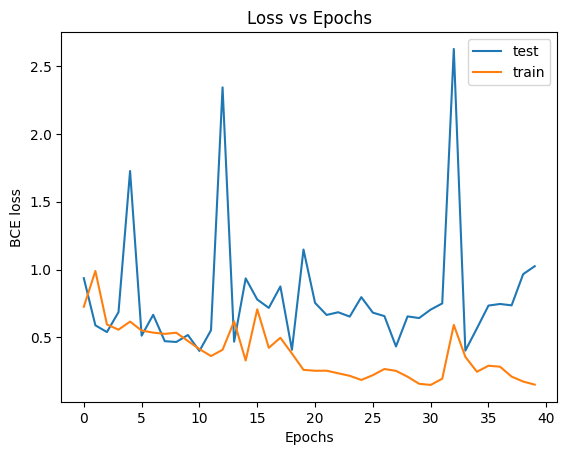

In [83]:

plt.plot(loss_stats['test'],label='test')
plt.plot(loss_stats['train'],label='train')
plt.legend(loc="best")
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE loss')

In [84]:
def conf_for_torch(predict,target):
    #round prediction
    round_pred=np.round(np.array(predict))
    conf_matrix = confusion_matrix(target, round_pred)
    return conf_matrix

In [85]:
# 2 116 12 | 116 182 test 71 71 | 76 130 
# 4  46 82 | 21 277 test  30 48 | 18 188
# seems to restart at each trail 
conf_test_m=conf_for_torch(m_test,target_test)
conf_train_m=conf_for_torch(m_train,target_train)
print("4 layer perceptron")
print("train")
print(conf_train_m)
print("test")
print(conf_test_m)
#some have 124 4 18 280 in train, test: 70 8 32 174

4 layer perceptron
train
[[124   4]
 [ 18 280]]
test
[[ 70   8]
 [ 32 174]]


Does not work relaible, but sometimes works at least in train. 

In [45]:
xc1=XGBClassifier(max_depth=6).fit(feature_train,target_train)

In [46]:
train_pred=xc1.predict(feature_train)
test_pred=xc1.predict(feature_test)
train_pred_prob=xc1.predict_proba(feature_train)
test_pred_prob=xc1.predict_proba(feature_test)
conf_train = confusion_matrix(target_train, train_pred)
conf_test = confusion_matrix(target_test, test_pred)
print("confusion matrix xgboost train")
print(conf_train)
print("confusion matrix xgboost test")
print(conf_test)

confusion matrix xgboost train
[[127   1]
 [  0 298]]
confusion matrix xgboost test
[[ 60  18]
 [ 28 178]]


Xgboost works at least approximate, while all networks do not yet work. 

In [47]:
lc1=LogisticRegression(max_iter=3000,penalty='none').fit(feature_train,target_train)

In [48]:
l_train_pred=lc1.predict(feature_train)
l_test_pred=lc1.predict(feature_test)
l_train_pred_prob=lc1.predict_proba(feature_train)
l_test_pred_prob=lc1.predict_proba(feature_test)
l_conf_train = confusion_matrix(target_train, l_train_pred)
l_conf_test = confusion_matrix(target_test, l_test_pred)
print("confusion matrix logistic regression train")
print(l_conf_train)
print("confusion matrix logistic regression test")
print(l_conf_test)

confusion matrix logistic regression train
[[128   0]
 [  0 298]]
confusion matrix logistic regression test
[[ 49  29]
 [ 91 115]]


Logistic works less good as xgboost but still better than neural networks. 

Test input outputs relations for convolutional network of 3 convolutional layers, it is still 3 *3 convolutional and 2 *2 maximuma.

In [86]:
input0 = torch.randn(1, 1, 43, 43)
b=torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0)
output0=b(input0)
print(f"first conv layer input: {input0.shape} output: {output0.shape}")

m = nn.MaxPool2d((2, 2), stride=(2, 2))
#standard drops but can be changed, can also use pooling and co get better number 
output1 = m(output0)
print(f"max pool input:{output0.shape} output:{output1.shape}")
#input format (Batch, Number Channels, height, width)
b2=torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)

output2=b2(output1)
print(f"second conv layer input: {output1.shape} output: {output2.shape}")
output3 = m(output2)
print(f"second max pool layer input: {output2.shape} output: {output3.shape}")

b3=torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)

output4=b3(output3)
print(f"third conv layer input: {output3.shape} output: {output4.shape}")
output5 = m(output4)
print(f"third max pool layer input: {output4.shape} output: {output5.shape}")

first conv layer input: torch.Size([1, 1, 43, 43]) output: torch.Size([1, 16, 41, 41])
max pool input:torch.Size([1, 16, 41, 41]) output:torch.Size([1, 16, 20, 20])
second conv layer input: torch.Size([1, 16, 20, 20]) output: torch.Size([1, 32, 18, 18])
second max pool layer input: torch.Size([1, 32, 18, 18]) output: torch.Size([1, 32, 9, 9])
third conv layer input: torch.Size([1, 32, 9, 9]) output: torch.Size([1, 64, 7, 7])
third max pool layer input: torch.Size([1, 64, 7, 7]) output: torch.Size([1, 64, 3, 3])


In [107]:
class CNNBinary4(torch.nn.Module):
    #no padding because image does not really end when the data ends. 
    def __init__(self):
        super(CNNBinary4, self).__init__()
        # L1 ImgIn shape=(?, 43, 43, 1)
        # Conv -> (?, 41, 41, 16)
        # Pool -> (?, 20, 20, 16)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L2 ImgIn shape=(?, 20, 20, 16)
        # Conv      ->(?, 18, 18, 32)
        # Pool      ->(?, 9, 9, 32)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L3 ImgIn shape=(?, 9, 9, 32)
        # Conv      ->(?, 7, 7, 64)
        # Pool      ->(?, 3, 3, 64)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))        
        # L3 FC 3x3x64 inputs -> 128 outputs
        self.fc1 = torch.nn.Linear(3 * 3 * 64, 128, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - keep_prob))
        # L4 Final FC 128 inputs -> 1 output
        self.fc2 = torch.nn.Linear(128, 1, bias=True) #
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out) #dont forget to add/omit layer here
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = torch.sigmoid(self.fc2(out))
        return out

In [108]:
keep_prob=1
model1 =CNNBinary4()
model1.to(device)
print(model1)
criterion = nn.BCELoss()
#once better when model0 parameters are used here 
optimizer = optim.Adam(model0.parameters(), lr=LEARNING_RATE)
#in loss_stats the statistic is collected 
loss_stats2 = {
    'train': [], 'test': []
}

CNNBinary4(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=576, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


/tmp/ipykernel_11915/994019738.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


In [109]:

print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    model1.train()
    for X_train_batch, y_train_batch in train_im_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model1(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        test_epoch_loss = 0
        
        model1.eval()
        for X_test_batch, y_test_batch in test_im_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            
            y_test_pred = model1(X_test_batch)
                        
            test_loss = criterion(y_test_pred, y_test_batch.unsqueeze(1))
            
            test_epoch_loss += test_loss.item()
    loss_stats2['train'].append(train_epoch_loss/len(train_im_loader))
    loss_stats2['test'].append(test_epoch_loss/len(test_im_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_im_loader):.5f} | Test Loss: {test_epoch_loss/len(test_im_loader):.5f}')

Begin training.


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 20.10609 | Test Loss: 14.42451
Epoch 002: | Train Loss: 19.19175 | Test Loss: 14.42451
Epoch 003: | Train Loss: 19.12191 | Test Loss: 14.42451
Epoch 004: | Train Loss: 19.07690 | Test Loss: 14.42451
Epoch 005: | Train Loss: 20.05906 | Test Loss: 14.42451
Epoch 006: | Train Loss: 20.71314 | Test Loss: 14.42451
Epoch 007: | Train Loss: 20.55008 | Test Loss: 14.42451
Epoch 008: | Train Loss: 19.68283 | Test Loss: 14.42451
Epoch 009: | Train Loss: 20.12651 | Test Loss: 14.42451
Epoch 010: | Train Loss: 19.63548 | Test Loss: 14.42451
Epoch 011: | Train Loss: 19.14027 | Test Loss: 14.42451
Epoch 012: | Train Loss: 19.22609 | Test Loss: 14.42451
Epoch 013: | Train Loss: 19.21640 | Test Loss: 14.42451
Epoch 014: | Train Loss: 18.71940 | Test Loss: 14.42451
Epoch 015: | Train Loss: 19.14049 | Test Loss: 14.42451
Epoch 016: | Train Loss: 18.58583 | Test Loss: 14.42451
Epoch 017: | Train Loss: 19.18065 | Test Loss: 14.42451
Epoch 018: | Train Loss: 20.61997 | Test Loss: 1

In [110]:
c_test=pred_torch(model1,test_im_loader)
c_train=pred_torch(model1,train_im_loader_pred)
print(c_train)

[0.9999719858169556, 0.9999911785125732, 1.0, 0.9999891519546509, 1.0, 0.9960888624191284, 0.9998372793197632, 1.0, 0.9987459182739258, 0.9999995231628418, 1.0, 1.0, 1.0, 0.9888305068016052, 0.9993904829025269, 0.9993915557861328, 1.0, 0.9999935626983643, 1.0, 0.9999803304672241, 0.9962537288665771, 0.9999942779541016, 0.9999924898147583, 0.9999727010726929, 1.0, 0.9999325275421143, 1.0, 1.0, 0.9999998807907104, 1.0, 0.9999871253967285, 0.9999970197677612, 0.9999992847442627, 1.0, 0.999947190284729, 0.9996308088302612, 1.0, 1.0, 0.999998927116394, 1.0, 1.0, 0.9999252557754517, 0.9996778964996338, 0.9999985694885254, 0.9896050691604614, 1.0, 1.0, 0.9999978542327881, 1.0, 1.0, 0.9995545744895935, 0.9996615648269653, 0.9994612336158752, 0.999876856803894, 0.9999986886978149, 0.9999954700469971, 0.9998409748077393, 1.0, 0.999998927116394, 0.9999072551727295, 0.9999996423721313, 0.9999510049819946, 0.9999814033508301, 1.0, 1.0, 1.0, 0.9986453652381897, 1.0, 0.9999910593032837, 0.99999988079

In [111]:
conf_test_c=conf_for_torch(c_test,target_test)
conf_train_c=conf_for_torch(c_train,target_train)
print("3 layer convolutional")
print("train")
print(conf_train_c)
print("test")
print(conf_test_c)

3 layer convolutional
train
[[  0 128]
 [  2 296]]
test
[[  0  78]
 [  0 206]]


Now not all the same prediction, but still no change in rediction during run. 

In [89]:
#define the function to fit it
#parameters: model used, train_data, test_data, epchs, batch_size, learning_rate, file to collect sats, 
#optional regularization 
def torch_fit(model,train_loader,test_loader,epochs,batch_size,learning_rate,loss_stats,l2reg=0):
    learning_rate = learning_rate
    criterion = torch.nn.BCELoss()    # Softmax is internally computed.
    #if no regularization
    if l2reg==0:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    #l2 regularization is added in optimizer as weight_decay=1e-5 or nsimilar 
    else:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate,weight_decay=l2reg)        
    print("Begin training.")
    for e in tqdm(range(1, epochs+1)):
    
        # TRAINING
        train_epoch_loss = 0
        model.train()
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            optimizer.zero_grad()
        
            y_train_pred = model(X_train_batch)
        
            train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
            train_loss.backward()
            optimizer.step()
        
            train_epoch_loss += train_loss.item()
        
        
        # VALIDATION    
        with torch.no_grad():
        
            test_epoch_loss = 0
        
            model.eval()
            for X_test_batch, y_test_batch in test_loader:
                X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            
                y_test_pred = model(X_test_batch)
                        
                test_loss = criterion(y_test_pred, y_test_batch.unsqueeze(1))
            
                test_epoch_loss += test_loss.item()
        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['test'].append(test_epoch_loss/len(test_loader))                              
    
        print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Test Loss: {test_epoch_loss/len(test_loader):.5f}')    

In [90]:
#somehow nothing improves like sometimes, unclear what is reason mistake in setup or real chance ? 
loss_stats_test = {
    'train': [], 'test': []
}
torch_fit(model1,train_im_loader,test_im_loader,3,32,0.01,loss_stats_test)

Begin training.


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 66.69819 | Test Loss: 72.53521
Epoch 002: | Train Loss: 70.93750 | Test Loss: 72.53521
Epoch 003: | Train Loss: 70.44643 | Test Loss: 72.53521


In [91]:
print(target_test,target_train.shape)

[1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0
 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0
 1 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 0 0 1 0 0 0
 1 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0
 1 1 1 1 0 0 1 0 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1
 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0
 1 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0 1 1 1] (426,)


In [92]:
c_test=pred_torch(model1,test_im_loader)
c_train=pred_torch(model1,train_im_loader_pred)

In [93]:
print(c_train)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,